In [89]:
! pip install yfinance pandas matplotlib

# Analyze Stock Monthly Return

## Util functions

In [83]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [84]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def fetch_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

def filter_month_data(data, months):
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    if len(months) == 1:
        return data[data['Month'] == months[0]]
    else:
        start_month, end_month = months
        if start_month <= end_month:
            return data[(data['Month'] >= start_month) & (data['Month'] <= end_month)]
        else:
            return data[(data['Month'] >= start_month) | (data['Month'] <= end_month)]

def calculate_period_performance(data, period, election_years_only=False):
    if election_years_only:
        data = data[data['Year'] % 4 == 0]

    performance = []
    years = data['Year'].unique()
    for year in years:
        period_data = data[data['Year'] == year]
        
        if period == "First Half":
            period_data = period_data[period_data.index.day <= 15]
        elif period == "Second Half":
            period_data = period_data[period_data.index.day > 15]
        
        if not period_data.empty:
            start_price = period_data['Close'].iloc[0]
            end_price = period_data['Close'].iloc[-1]
            change = (end_price - start_price) / start_price * 100
            performance.append({"Year": year, "Performance (%)": round(change, 1)})

    return pd.DataFrame(performance)

def plot_performance(performance_df, months, period, election_years_only, ticker):
    plt.figure(figsize=(14, 7))
    plt.bar(performance_df['Year'], performance_df['Performance (%)'], color='blue')
    plt.xlabel('Year')
    plt.ylabel('Performance (%)')
    if len(months) == 1:
        title = f'{ticker} {datetime(1, months[0], 1).strftime("%B")} {period} Performance'
    else:
        start_month, end_month = months
        title = f'{ticker} {datetime(1, start_month, 1).strftime("%B")}-{datetime(1, end_month, 1).strftime("%B")} Performance'
    if election_years_only:
        title += ' in Election Years'
    plt.title(title)
    plt.grid(True)
    plt.show()

def analyze_ticker_performance(ticker, months, num_years, election_years_only):
    # Define the time period for the specified number of years
    end_date = datetime.today()
    start_date = (end_date - timedelta(days=num_years * 365)).replace(day=1)
    end_date = end_date.strftime('%Y-%m-%d')
    start_date = start_date.strftime('%Y-%m-%d')

    # Fetch the historical data
    data = fetch_data(ticker, start_date, end_date)

    # Filter the data for the selected months
    month_data = filter_month_data(data, months)

    if len(months) == 1:
        # Calculate the performance for the entire month, first half, and second half
        performance_entire_month = calculate_period_performance(month_data, "Entire Month", election_years_only)
        performance_first_half = calculate_period_performance(month_data, "First Half", election_years_only)
        performance_second_half = calculate_period_performance(month_data, "Second Half", election_years_only)

        # Plot the performance
        plot_performance(performance_entire_month, months, "Entire Month", election_years_only, ticker)
        plot_performance(performance_first_half, months, "First Half", election_years_only, ticker)
        plot_performance(performance_second_half, months, "Second Half", election_years_only, ticker)
    else:
        # Calculate the performance for the specified period
        performance_df = calculate_period_performance(month_data, "Entire Month", election_years_only)

        # Display the performance DataFrame
        print(performance_df)

        # Plot the performance
        plot_performance(performance_df, months, "Entire Month", election_years_only, ticker)

## Params 

[*********************100%%**********************]  1 of 1 completed


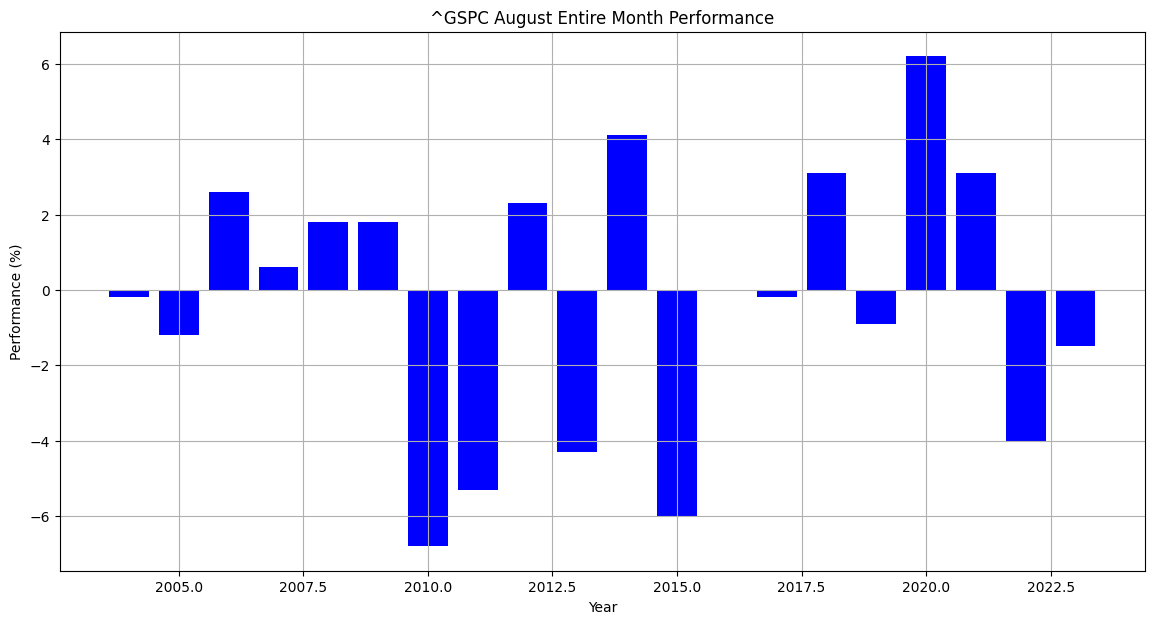

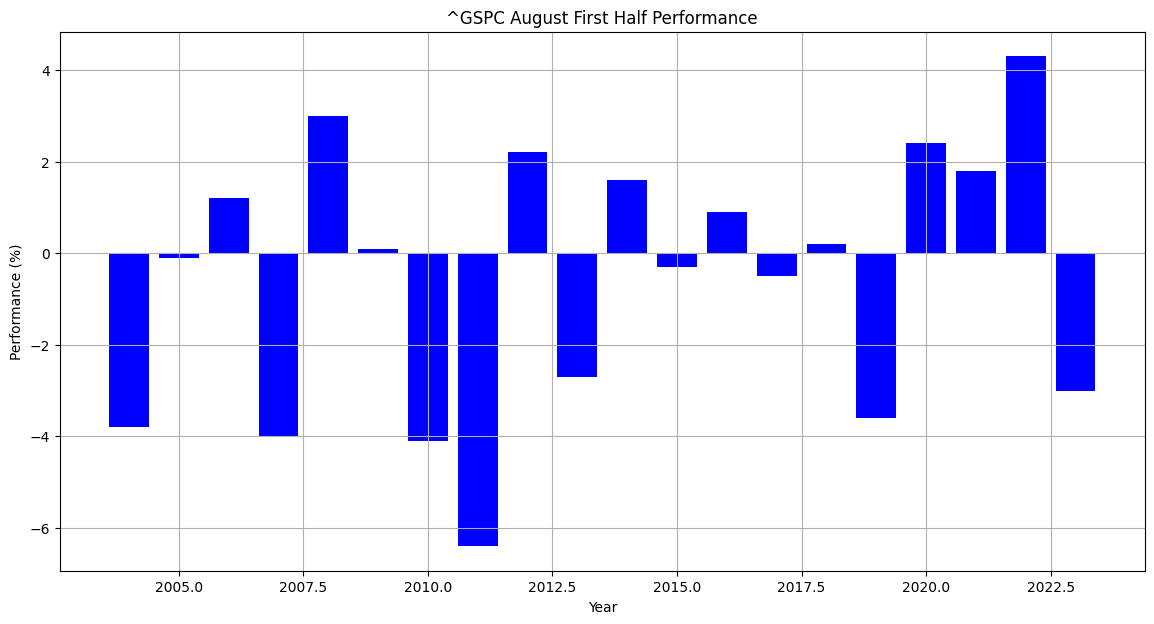

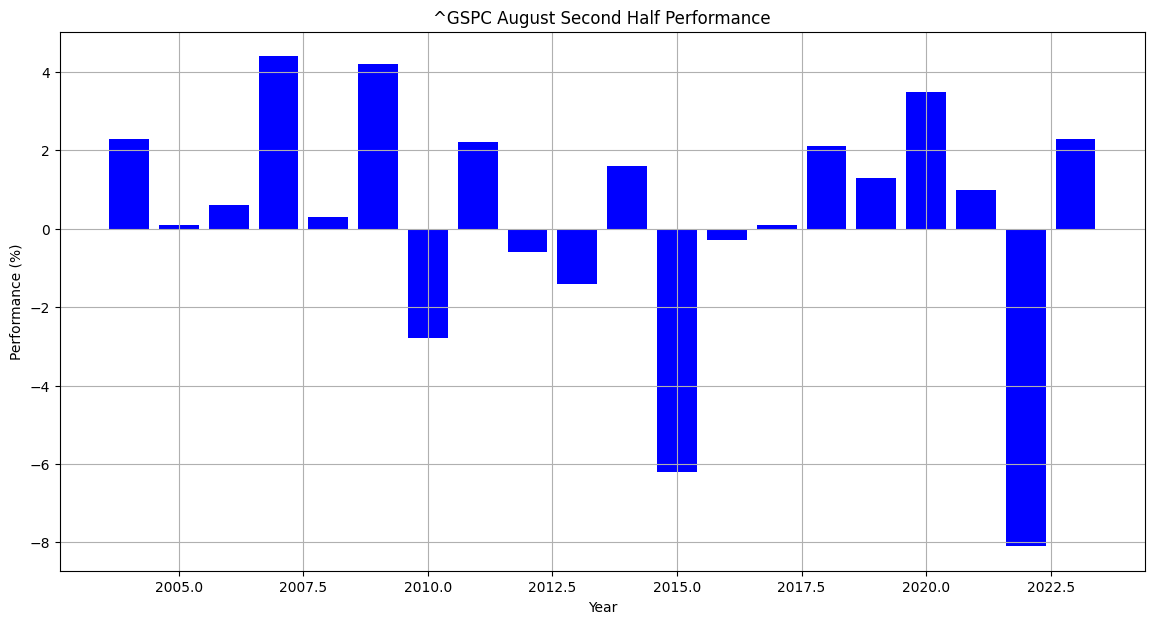

[*********************100%%**********************]  1 of 1 completed


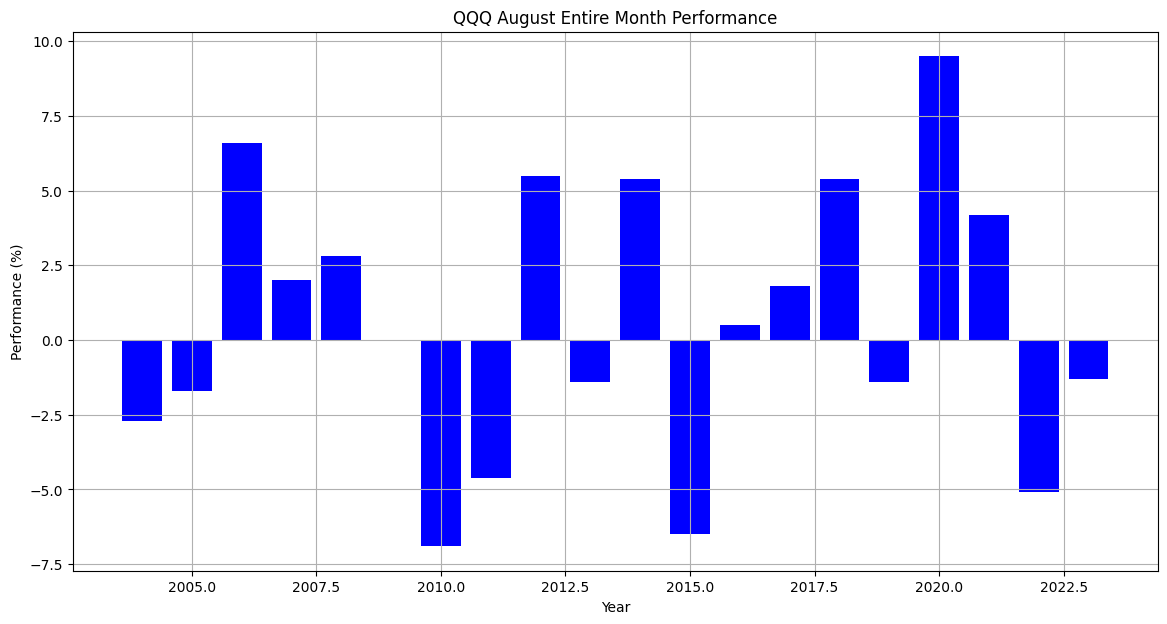

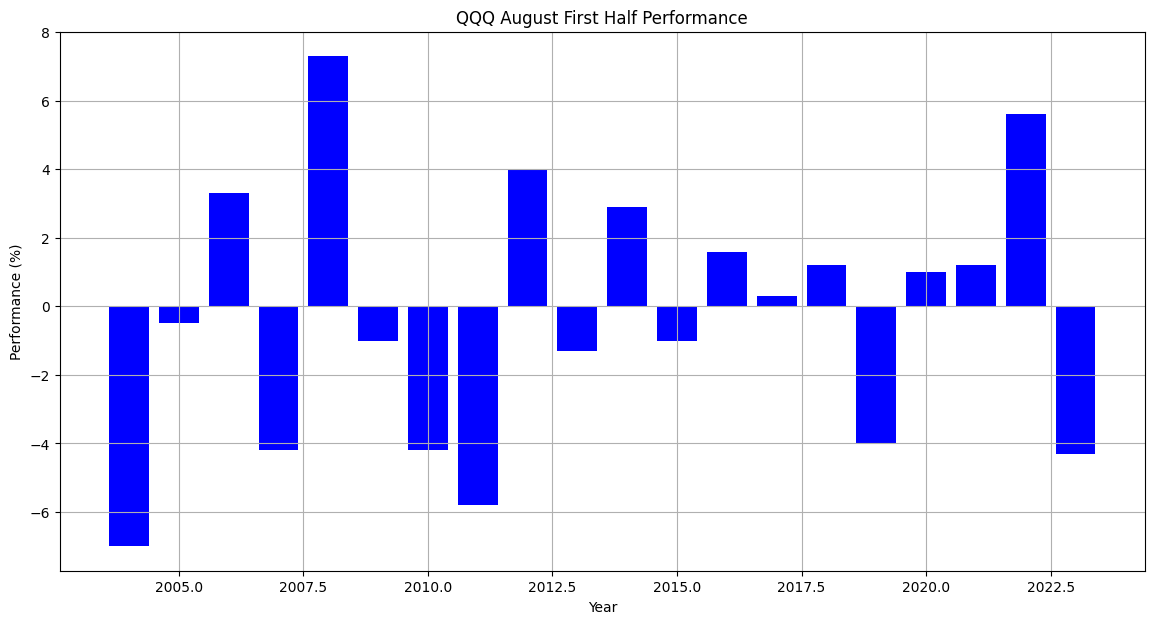

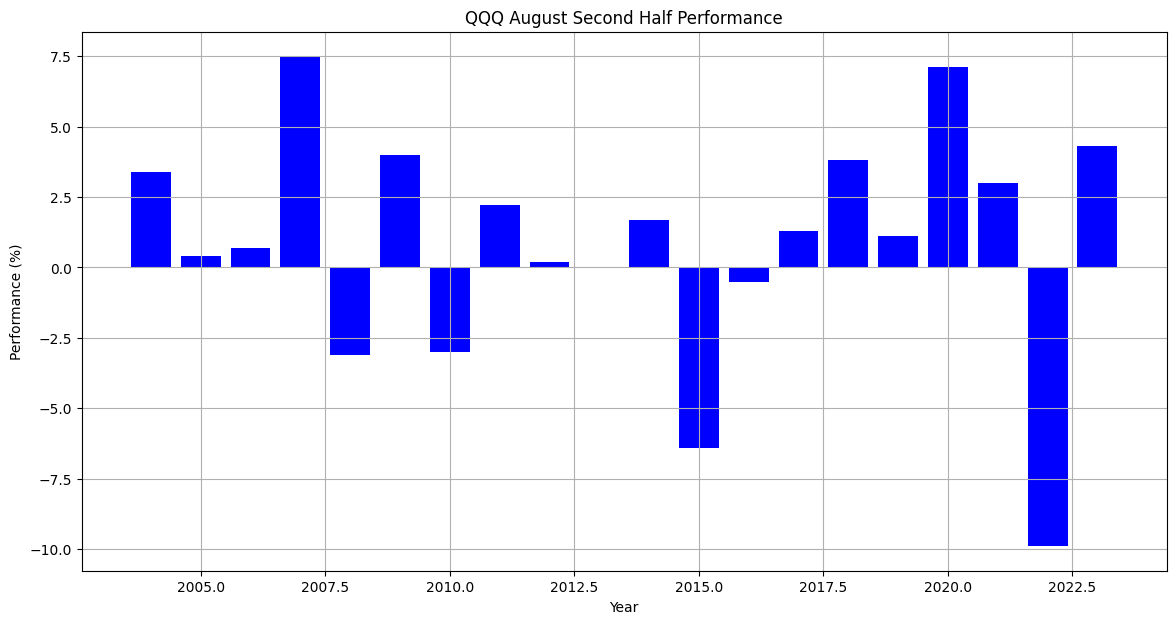

[*********************100%%**********************]  1 of 1 completed


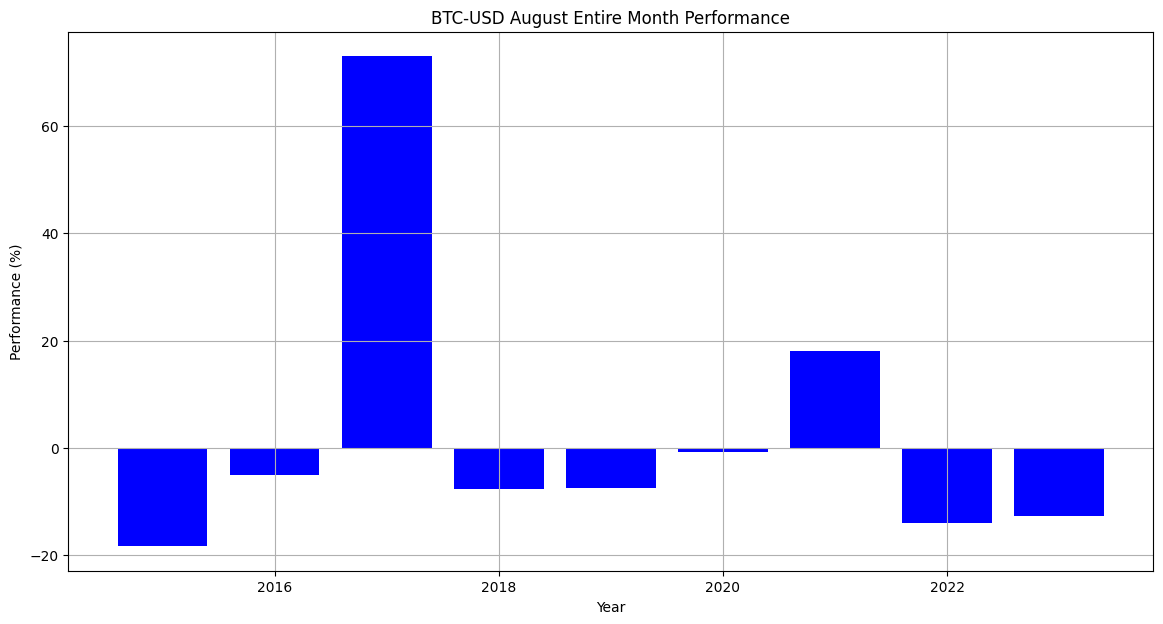

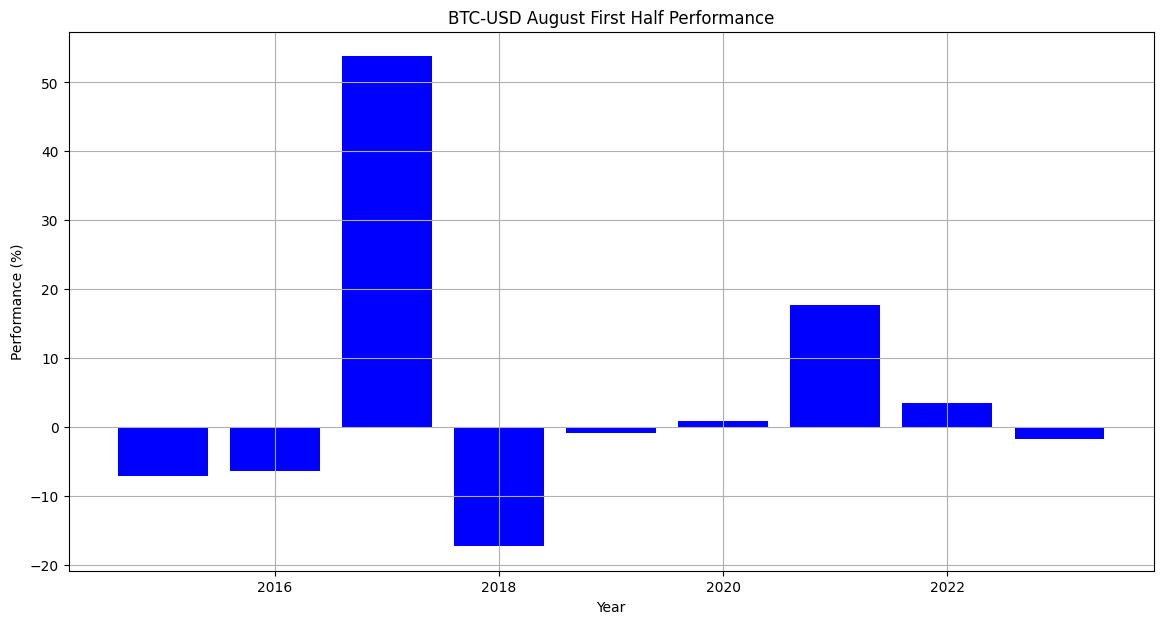

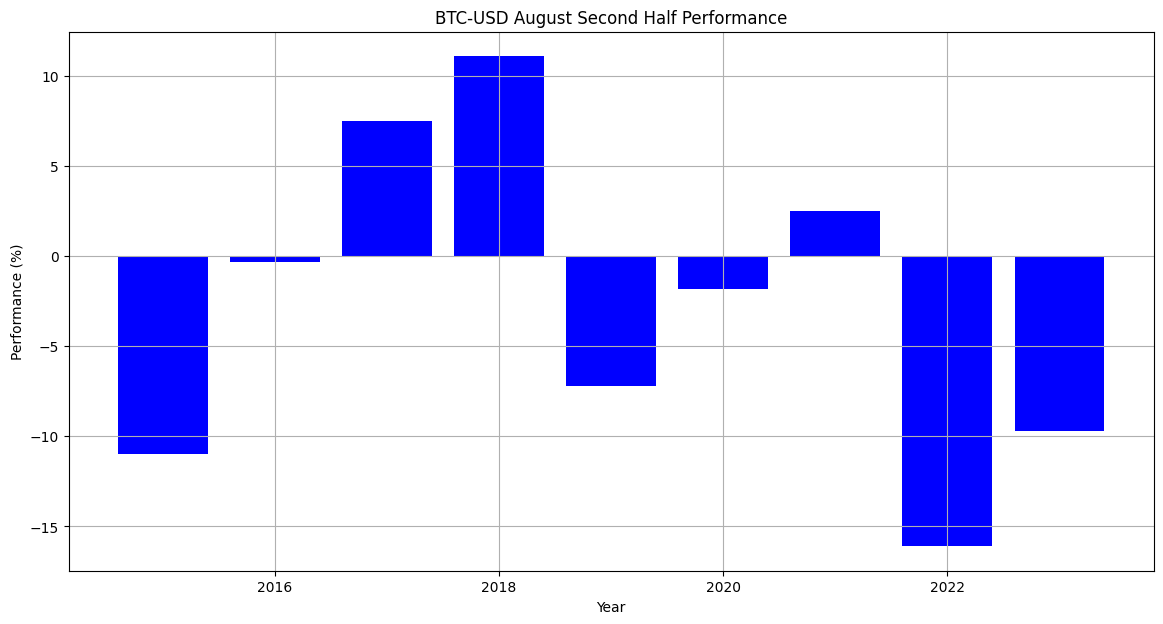

In [87]:
# Parameters
tickers = ["^GSPC", "QQQ", "BTC-USD"]  # List of ticker symbols for S&P 500 and Bitcoin
#tickers = ["BTC-USD"]  # List of ticker symbols for S&P 500 and Bitcoin
months = [8]  # Range of months to analyze (e.g., [1, 12] for January to December)
num_years = 20  # Number of years for analysis
election_years_only = False  # Whether to filter for election years only

# Analyze performance for each ticker
for ticker in tickers:
    analyze_ticker_performance(ticker, months, num_years, election_years_only)

# BTC Price analysis 

In [88]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def fetch_data(ticker, num_years):
    """Fetch historical data for a given ticker for the last num_years years."""
    end_date = datetime.today()
    start_date = end_date - timedelta(days=num_years * 365)
    return yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

def calculate_daily_performance(data):
    """Calculate the daily performance as percentage increase from open to close."""
    data['Daily Performance (%)'] = ((data['Close'] - data['Open']) / data['Open']) * 100
    return data

def get_top_performing_days_per_year(data, top_n=10):
    """Get the top N performing days per year based on daily performance."""
    data = data.reset_index()  # Ensure the date is a column
    top_days = data.groupby(data['Date'].dt.year).apply(lambda x: x.nlargest(top_n, 'Daily Performance (%)')).reset_index(drop=True)
    return top_days

def calculate_annual_return(data):
    """Calculate annual return."""
    if 'Date' in data.columns:
        data = data.set_index('Date')
    annual_returns = data.groupby(data.index.year).apply(lambda x: (x['Close'].iloc[-1] - x['Close'].iloc[0]) / x['Close'].iloc[0] * 100)
    return annual_returns

def main(ticker, num_years, top_n):
    # Fetch historical data
    data = fetch_data(ticker, num_years)
    
    # Calculate daily performance
    data = calculate_daily_performance(data)
    
    # Get the top performing days per year
    top_days = get_top_performing_days_per_year(data, top_n)
    
    # Reset the index for data to ensure 'Date' is accessible
    data = data.reset_index()
    
    # Calculate annual returns with top n days
    annual_return_with_top_days = calculate_annual_return(data)
    
    # Calculate the sum of the top n days' performances per year
    top_days_performance_sum = top_days.groupby(top_days['Date'].dt.year)['Daily Performance (%)'].sum()
    
    # Calculate annual returns without top n days by subtracting the sum of top n days' performances
    annual_return_without_top_days = annual_return_with_top_days - top_days_performance_sum
    
    # Display the results in a human-readable format
    print(f"Top {top_n} performing days per year for {ticker} in the last {num_years} years:\n")
    grouped = top_days.groupby(top_days['Date'].dt.year)
    for year, group in grouped:
        print(f"Year: {year}")
        for index, row in group.iterrows():
            print(f"  Date: {row['Date'].date()}, Open: {row['Open']:.2f}, Close: {row['Close']:.2f}, Performance: {row['Daily Performance (%)']:.2f}%")
        print(f"Annual return with top {top_n} days: {annual_return_with_top_days.loc[year]:.2f}%")
        print(f"Annual return without top {top_n} days: {annual_return_without_top_days.loc[year]:.2f}%")
        print("\n")
    
    return top_days

# Parameters
ticker = "BTC-USD"  # Ticker symbol for Bitcoin in USD
num_years = 15  # Number of years for analysis
top_n = 30  # Top N performing days per year to display

# Run the analysis
top_performing_days = main(ticker, num_years, top_n)

[*********************100%%**********************]  1 of 1 completed

Top 30 performing days per year for BTC-USD in the last 15 years:

Year: 2014
  Date: 2014-11-12, Open: 367.98, Close: 423.56, Performance: 15.10%
  Date: 2014-09-23, Open: 402.09, Close: 435.79, Performance: 8.38%
  Date: 2014-11-09, Open: 345.38, Close: 363.26, Performance: 5.18%
  Date: 2014-10-08, Open: 336.12, Close: 352.94, Performance: 5.01%
  Date: 2014-10-12, Open: 362.61, Close: 378.55, Performance: 4.40%
  Date: 2014-11-23, Open: 353.17, Close: 367.57, Performance: 4.08%
  Date: 2014-12-20, Open: 317.62, Close: 329.96, Performance: 3.88%
  Date: 2014-09-20, Open: 394.67, Close: 408.90, Performance: 3.61%
  Date: 2014-11-16, Open: 374.73, Close: 387.88, Performance: 3.51%
  Date: 2014-10-09, Open: 352.75, Close: 365.03, Performance: 3.48%
  Date: 2014-12-22, Open: 321.07, Close: 331.89, Performance: 3.37%
  Date: 2014-10-13, Open: 377.92, Close: 390.41, Performance: 3.31%
  Date: 2014-10-06, Open: 320.39, Close: 330.08, Performance: 3.02%
  Date: 2014-12-31, Open: 310.91, Clo